In [1]:
!which python 
!whoami 
!hostname
!pwd

/home/farshed.abdukhakimov/miniconda3/envs/root-newton/bin/python
farshed.abdukhakimov
cn-02
/home/farshed.abdukhakimov/projects/root-newton


In [4]:
%load_ext autoreload
%autoreload 2

import os
import sys
import urllib.request
import datetime
from collections import defaultdict

# module_path = os.path.abspath(os.path.join('..'))
# if module_path not in sys.path:
#     sys.path.append(module_path)

import numpy as np
import scipy

import matplotlib.pyplot as plt

from dotenv import load_dotenv
load_dotenv()

import utils
from losses import LogisticRegressionLoss

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [5]:
np.random.seed(0)
loss_function = LogisticRegressionLoss()
data, target = utils.get_LIBSVM(dataset_name="phishing")
if isinstance(loss_function, LogisticRegressionLoss):
    target = utils.map_classes_to(target, [-1.0, 1.0])

In [6]:
if loss_function == lgstc:
    train_target[train_target == train_target.unique()[0]] = torch.tensor(-1.0, dtype=torch.get_default_dtype())
    train_target[train_target == train_target.unique()[1]] = torch.tensor(1.0, dtype=torch.get_default_dtype())
    assert torch.equal(train_target.unique(), torch.tensor([-1.0, 1.0]))

In [35]:
np.unique(train_target)

array([-1.,  1.])

# Damped Newton


In [8]:
def damped_newton(w: np.ndarray, grad: np.ndarray, 
                  hess: np.ndarray, lr: float = 1.0) -> np.ndarray:
    
    n = np.linalg.solve(hess, grad)
    hess_inv = np.linalg.inv(hess)
    n = hess_inv @ grad
    w = w - lr*n
        
    return w

# Gradient Regularization of Newton Method
### Algorithm 1 in `Super-Universal Regularized Newton Method`

In [9]:
def gradreg_newton(w: np.ndarray, grad: np.ndarray, hess: np.ndarray,
                   q : float = 2.0, L_est: float | None = None) -> np.ndarray:
    
    if L_est == None:
        L = np.linalg.norm(hess, ord=2)
    else:
        L = L_est
    
    B = np.eye(w.shape[0])
    n = np.linalg.solve(hess, grad)
    g = np.sqrt(grad.dot(n))
    lambda_k = (6 * L * g**(q - 2))**(1 / (q - 1))
    try:
        # Compute the regularized Newton step
        delta_w = scipy.linalg.cho_solve(scipy.linalg.cho_factor(
                        hess + lambda_k * B, lower=False), -grad)
    except (np.linalg.LinAlgError, ValueError) as e:
        print('W: linalg_error', flush=True)
        
    w += delta_w
    
    return w

# Super Newton
### Algorithm 2 in `Super-Universal Regularized Newton Method`

In [10]:
def super_newton(n_steps=100, H_0=1.0, alpha=1.0, 
                 adaptive_search=True, eps=1e-8, 
                 H_min=1e-5, f_star=None, seed=0):
    np.random.seed(seed)
    
    w = np.zeros((train_data.shape[1]))

    B = np.eye(w.shape[0])  
    
    H_k = H_0
    
    loss = loss_function(w, train_data, train_target)
    grad = loss_grad(w, train_data, train_target)
    grad_norm = grad.dot(grad) ** 0.5
    hess = loss_hessian(w, train_data, train_target)
    
    # logging 
    history = defaultdict(list)
    start_timestamp = datetime.datetime.now()
    
    # Main loop
    for step in range(n_steps):
        
        print(f"Step: [{step}/{n_steps}]")
        time = (datetime.datetime.now() - start_timestamp).total_seconds()
        acc = (np.sign(train_data @ w) == train_target).sum() / train_target.shape[0]
        
        print(f"Loss: {loss} | GradNorm^2: {(np.linalg.norm(grad) ** 2 )} | Acc: {acc}")
        history["loss"].append(loss)
        history["grad_norm"].append(np.linalg.norm(grad) ** 2)
        history["accuracy"].append(acc)
        history["time"].append(time)
        
        adaptive_search_max_iter = 40
        for i in range(adaptive_search_max_iter + 1):
            if i == adaptive_search_max_iter:
                print(('W: adaptive_iterations_exceeded, step = %d' % step), flush=True)
                break

            lambda_k = H_k * grad_norm ** alpha
            try:
                # Compute the regularized Newton step
                delta_w = scipy.linalg.cho_solve(scipy.linalg.cho_factor(
                                hess + lambda_k * B, lower=False), -grad)
            except (np.linalg.LinAlgError, ValueError) as e:
                print('W: linalg_error', flush=True)

            loss_new = loss_function(w + delta_w, train_data, train_target)
            grad_new = loss_grad(w + delta_w, train_data, train_target)
            grad_norm_new_sqrd = grad_new.dot(grad_new) # squared norm of gradient at (w + delta_w) 

            # Check condition for H_k
            if grad_new.dot(-delta_w) >= grad_norm_new_sqrd / (4 * lambda_k):
                H_k *= 0.25
                H_k = max(H_k, H_min)
                break
            
            H_k *= 4
            
        # Update the point
        w += delta_w
        loss = loss_new
        grad = grad_new
        grad_norm = grad_norm_new_sqrd ** 0.5
        

    return history

# UN: Universal Newton

In [11]:
def universal_newton(n_steps : int = 100, beta: float = 1.0, 
                     sigma : float = 1.0, c : float = 1.0, seed : int = 0):
    np.random.seed(seed)
    
    w = np.zeros((train_data.shape[1]))
    
    # logging 
    history = defaultdict(list)
    start_timestamp = datetime.datetime.now()
    
    # Main loop
    for step in range(n_steps):

        print(f"Step: [{step}/{n_steps}]")
        time = (datetime.datetime.now() - start_timestamp).total_seconds()
        
        loss = loss_function(w, train_data, train_target)
        grad = loss_grad(w, train_data, train_target)
        grad_norm = grad.dot(grad) ** 0.5
        hess = loss_hessian(w, train_data, train_target)        
        acc = (np.sign(train_data @ w) == train_target).sum() / train_target.shape[0]
        
        print(f"Loss: {loss} | GradNorm^2: {(np.linalg.norm(grad) ** 2 )} | Acc: {acc}")
        history["loss"].append(loss)
        history["grad_norm"].append(np.linalg.norm(grad) ** 2)
        history["accuracy"].append(acc)
        history["time"].append(time)
        
        n = np.linalg.solve(hess, grad)
        g = np.sqrt(grad.dot(n))
        
        adaptive_search_max_iter = 40
        for j in range(adaptive_search_max_iter + 1):
            if j == adaptive_search_max_iter:
                print(('W: adaptive_iterations_exceeded, step = %d' % step), flush=True)
                break
            
            theta = c**j * sigma * g**beta
            alpha = 1 / (1 + theta)
            w_j = w - alpha * n

            # Check condition for H_k
            grad_new = loss_grad(w_j, train_data, train_target)
            n_j = np.linalg.solve(hess, grad_new)
            g_j_sq = grad_new.dot(n_j)
            if grad_new.dot(n) >= g_j_sq / (2 * alpha * theta):
                # Update the parameters
                w = w_j
                sigma = sigma * c**(j - 1)
                break

    return history

# AICN

In [12]:
def aic_newton(w: np.ndarray, grad: np.ndarray, hess: np.ndarray,
               L_est: float | None = None) -> np.ndarray:
    
    if L_est == None:
        L = np.linalg.norm(hess, ord=2)
    else:
        L = L_est
        
    n = np.linalg.solve(hess, grad)
    g = np.sqrt(grad.dot(n))
    lr = (np.sqrt(1 + 2 * L * g) - 1) / (L * g)
    w = w - lr*n 
    
    return w

# Root Newton

Let $q = p + \nu$, where $q \in [2, 4]$ and $\nu \in [0, 1]$  
$p$ is a parameter for $p$-times differentiable function  
$\nu$ is a parameter for smoothness, i.e. smaller $\nu$ means greater smoothnees  
Theoretical $M_q$ is calculated as $M_q = L_{p, \nu}$ defined in Eq. (28).  

From Lemma 1.2.2 in [1] we know that $\| \nabla^2 f(x) \|_{op} \leq L_{2, 1}, \;\; \forall x \in \mathbb{R} $  
$\| A \|_{op} = \sigma_{max}(A) = \sqrt{\lambda_{max}(A^TA)}$ (maximum singular value of matrix A)  
Hence each iteration we set $M_q = $ `np.linalg.norm(hess, ord=2)` which returns $\|\nabla^2f(x_k)\|_{op}$  

___
*References*  
[1] Yurii Nesterov. 2014. Introductory Lectures on Convex Optimization: A Basic Course (1st. ed.). Springer Publishing Company, Incorporated.

In [13]:
def root_newton(w: np.ndarray, grad: np.ndarray, hess: np.ndarray, 
                q: float, L_est: float | None = None) -> np.ndarray:
    
    if L_est == None:
        L = np.linalg.norm(hess, ord=2)
    else:
        L = L_est
    
    n = np.linalg.solve(hess, grad)
    g = np.sqrt(grad.dot(n))
    theta = (9 * L)**(1 / (q - 1)) * g**((q - 2) / (q - 1))
    lr = 1 / (1 + theta)
    w = w - lr*n 
        
    return w

In [14]:
def train_loop(
    method: str,
    lr: float = 1.0,
    n_steps: int = 100,
    seed: int = 0,
    q : float = 2.0,
    L_est: float | None = 1.0,
    ) -> dict:

    np.random.seed(seed)
    
    # parameters
    w = np.zeros((train_data.shape[1]))
    
    # logging 
    history = defaultdict(list)
    
    start_timestamp = datetime.datetime.now()
    
    assert method in ["damped_newton", "root_newton", "aic_newton", "gradreg_newton"]
    
    for step in range(n_steps):

        print(f"Step: [{step}/{n_steps}]")
        time = (datetime.datetime.now() - start_timestamp).total_seconds()
        loss = loss_function(w, train_data, train_target)
        grad = loss_grad(w, train_data, train_target)
        hess = loss_hessian(w, train_data, train_target)
        acc = (np.sign(train_data @ w) == train_target).sum() / train_target.shape[0]
        
        if method == "damped_newton":
            w = damped_newton(w, grad, hess, lr)
        elif method == "root_newton":
            w = root_newton(w, grad, hess, q, L_est)
        elif method == "aic_newton":
            w = aic_newton(w, grad, hess, L_est)
        elif method == "gradreg_newton":
            w = gradreg_newton(w, grad, hess, q, L_est)
        
        print(f"Loss: {loss} | GradNorm^2: {(np.linalg.norm(grad) ** 2 )} | Acc: {acc}")
        history["loss"].append(loss)
        history["grad_norm"].append(np.linalg.norm(grad) ** 2)
        history["accuracy"].append(acc)
        history["time"].append(time)
    
    return history

Step: [0/30]
Loss: 0.6931471805599454 | GradNorm^2: 0.16975426525350082 | Acc: 0.0
Step: [1/30]
Loss: 0.3010074096491049 | GradNorm^2: 0.01626158396136787 | Acc: 0.963
Step: [2/30]
Loss: 0.18002611237131041 | GradNorm^2: 0.002874757203160777 | Acc: 0.984
Step: [3/30]
Loss: 0.11017629541640263 | GradNorm^2: 0.000557836125613199 | Acc: 0.994
Step: [4/30]
Loss: 0.06549434184644339 | GradNorm^2: 0.0001170435865168343 | Acc: 0.994
Step: [5/30]
Loss: 0.036576253287795964 | GradNorm^2: 2.5863596045139883e-05 | Acc: 0.996
Step: [6/30]
Loss: 0.018251979081351472 | GradNorm^2: 5.1467114497218446e-06 | Acc: 1.0
Step: [7/30]
Loss: 0.007909035594314396 | GradNorm^2: 9.603497882271e-07 | Acc: 1.0
Step: [8/30]
Loss: 0.0030935262033209574 | GradNorm^2: 1.534645369989697e-07 | Acc: 1.0
Step: [9/30]
Loss: 0.0011648146492811524 | GradNorm^2: 2.209514527865549e-08 | Acc: 1.0
Step: [10/30]
Loss: 0.00043445736741534025 | GradNorm^2: 3.0912690883084753e-09 | Acc: 1.0
Step: [11/30]
Loss: 0.0001614151485458578

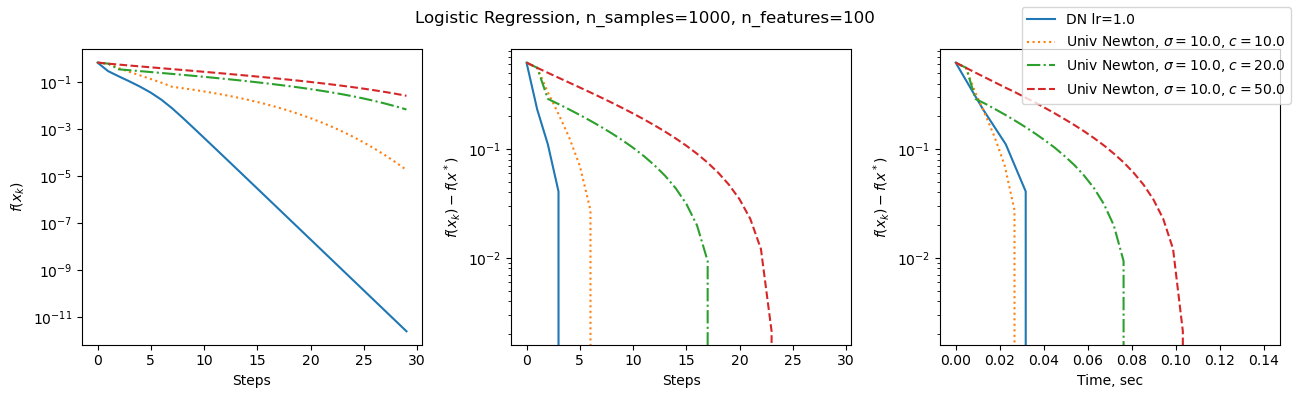

In [15]:
np.random.seed(0)

n_steps = 30
fig, ax = plt.subplots(1, 3, figsize=(13, 4))

# Damped Newton
lr = 1.0
hist = train_loop(method="damped_newton", lr=lr, n_steps=n_steps)
residual_loss = hist["loss"] - loss_function(w_star, train_data, train_target)
ax[0].semilogy(hist["loss"])
ax[1].semilogy(residual_loss)
ax[2].semilogy(hist["time"], residual_loss, label=f"DN lr={lr}")


# Universal Newton
for c, sigma, ls in zip([10.0, 20.0, 50.0], [10.0, 10.0, 10.0], [":", "-.", "--"]):
    hist = universal_newton(n_steps=n_steps, beta=2/3, sigma=sigma, c=c)
    residual_loss = hist["loss"] - loss_function(w_star, train_data, train_target)
    ax[0].semilogy(hist["loss"], linestyle=ls)
    ax[1].semilogy(residual_loss, linestyle=ls)
    ax[2].semilogy(hist["time"], residual_loss, linestyle=ls, label=r"Univ Newton, $\sigma={0}$, $c={1}$".format(sigma, c))


        
plt.suptitle(f"Logistic Regression, n_samples={n_samples}, n_features={n_features}")
ax[0].set_ylabel(r"$f(x_k)$")
ax[0].set_xlabel("Steps")
ax[1].set_ylabel(r"$f(x_k) - f(x^*)$")
ax[1].set_xlabel("Steps")
ax[2].set_ylabel(r"$f(x_k) - f(x^*)$")
ax[2].set_xlabel("Time, sec")

fig.legend()
fig.tight_layout()
fig.show()   

Step: [0/20]
Loss: 0.6931471805599454 | GradNorm^2: 0.16975426525350082 | Acc: 0.0
Step: [1/20]
Loss: 0.3010074096491049 | GradNorm^2: 0.01626158396136787 | Acc: 0.963
Step: [2/20]
Loss: 0.18002611237131044 | GradNorm^2: 0.0028747572031607754 | Acc: 0.984
Step: [3/20]
Loss: 0.11017629541640261 | GradNorm^2: 0.000557836125613199 | Acc: 0.994
Step: [4/20]
Loss: 0.0654943418464434 | GradNorm^2: 0.00011704358651683422 | Acc: 0.994
Step: [5/20]
Loss: 0.03657625328779601 | GradNorm^2: 2.5863596045139937e-05 | Acc: 0.996
Step: [6/20]
Loss: 0.018251979081351587 | GradNorm^2: 5.146711449721836e-06 | Acc: 1.0
Step: [7/20]
Loss: 0.007909035594314507 | GradNorm^2: 9.603497882271233e-07 | Acc: 1.0
Step: [8/20]
Loss: 0.003093526203320974 | GradNorm^2: 1.534645369989751e-07 | Acc: 1.0
Step: [9/20]
Loss: 0.0011648146492811518 | GradNorm^2: 2.209514527865549e-08 | Acc: 1.0
Step: [10/20]
Loss: 0.0004344573674153469 | GradNorm^2: 3.0912690883085733e-09 | Acc: 1.0
Step: [11/20]
Loss: 0.0001614151485458598

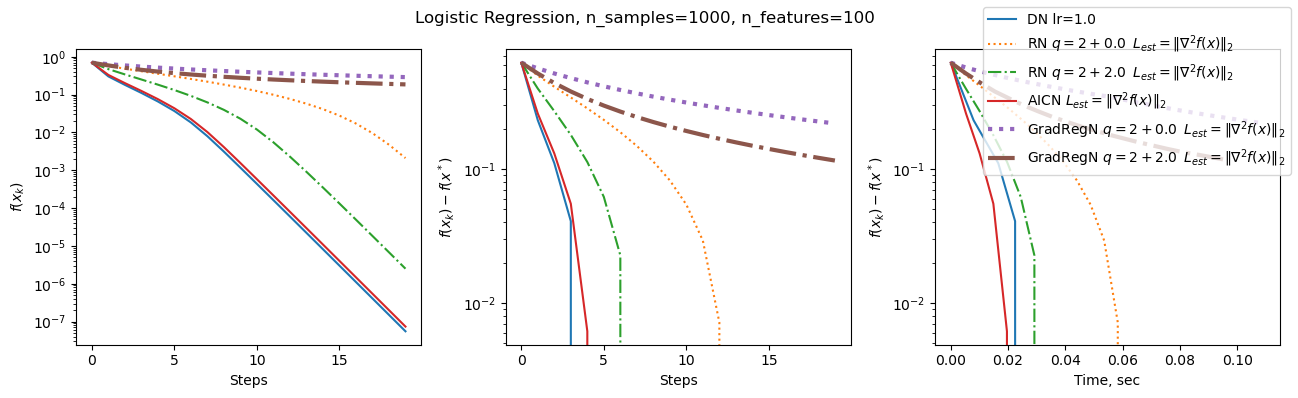

In [18]:
np.random.seed(0)

n_steps = 20
fig, ax = plt.subplots(1, 3, figsize=(13, 4))

# Damped Newton
lr = 1.0
hist = train_loop(method="damped_newton", lr=lr, n_steps=n_steps)
residual_loss = hist["loss"] - loss_function(w_star, train_data, train_target)
ax[0].semilogy(hist["loss"])
ax[1].semilogy(residual_loss)
ax[2].semilogy(hist["time"], residual_loss, label=f"DN lr={lr}")

# Root Newton
for nu, ls in zip([0.0, 2.0], [":", "-."]):
    hist = train_loop(method="root_newton", n_steps=n_steps, q=2+nu, L_est=None)
    
    residual_loss = hist["loss"] - loss_function(w_star, train_data, train_target)
    ax[0].semilogy(hist["loss"], linestyle=ls)
    ax[1].semilogy(residual_loss, linestyle=ls)
    ax[2].semilogy(hist["time"], residual_loss, linestyle=ls, label=r"RN $q = 2 + {0} \;\; L_{{est}}=\| \nabla^2 f(x) \|_2$".format(nu))
    
        
# AICN
hist = train_loop(method="aic_newton", n_steps=n_steps, L_est=None)
residual_loss = hist["loss"] - loss_function(w_star, train_data, train_target)
ax[0].semilogy(hist["loss"])
ax[1].semilogy(residual_loss)
ax[2].semilogy(hist["time"], residual_loss, label=r"AICN $L_{est}=\| \nabla^2 f(x) \|_2$")

# Gradient Regularization of Newton
for nu, ls in zip([0.0, 2.0], [":", "-."]):
    hist = train_loop(method="gradreg_newton", n_steps=n_steps, q=2+nu, L_est=None)
    
    residual_loss = hist["loss"] - loss_function(w_star, train_data, train_target)
    ax[0].semilogy(hist["loss"], linestyle=ls, linewidth=3.0)
    ax[1].semilogy(residual_loss, linestyle=ls, linewidth=3.0)
    ax[2].semilogy(hist["time"], residual_loss, linestyle=ls, linewidth=3.0, label=r"GradRegN $q = 2 + {0} \;\; L_{{est}}=\| \nabla^2 f(x) \|_2$".format(nu))
    

# Super Newton
# hist = super_newton(n_steps=n_steps)
# residual_loss = hist["loss"] - loss_function(w_star, train_data, train_target)
# ax[0].semilogy(hist["loss"])
# ax[1].semilogy(residual_loss)
# ax[2].semilogy(hist["time"], residual_loss, label="Super-Univ")


        
plt.suptitle(f"Logistic Regression, n_samples={n_samples}, n_features={n_features}")
ax[0].set_ylabel(r"$f(x_k)$")
ax[0].set_xlabel("Steps")
ax[1].set_ylabel(r"$f(x_k) - f(x^*)$")
ax[1].set_xlabel("Steps")
ax[2].set_ylabel(r"$f(x_k) - f(x^*)$")
ax[2].set_xlabel("Time, sec")

fig.legend()
fig.tight_layout()
fig.show()   

In [19]:
from datetime import datetime

start_timestamp = datetime.now()
sorted(np.random.randn(1000000))
(datetime.now() - start_timestamp).total_seconds()

0.662989

In [20]:
from collections import defaultdict

defaultdict(list)

defaultdict(list, {})

NameError: name 'train' is not defined

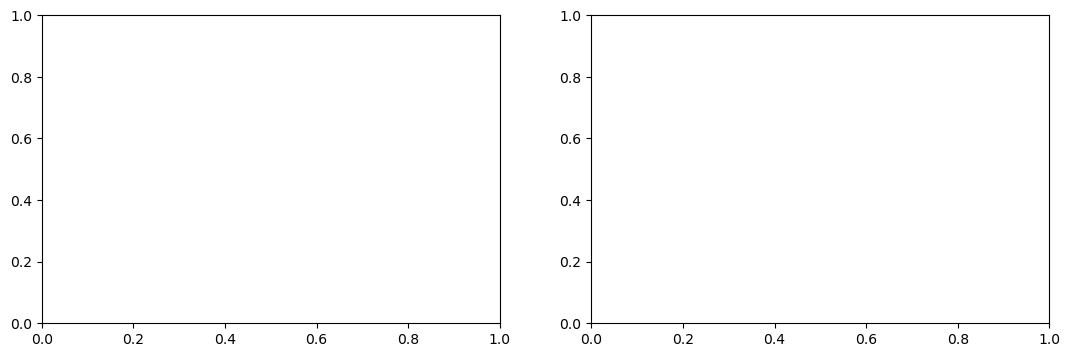

In [30]:
torch.manual_seed(0)

for M, ls in zip((0.01, 1.0, 20.0), ("-", "--", "-.")):
    fig, ax = plt.subplots(1, 2, figsize=(13, 4))
    
    for q in (2, 3, 4):

        epochs = 100
        data, target, dataloader = train

        # parameters
        w = torch.zeros(data.shape[1], device=device)

        # logging 
        hist = []
        hist_batch = []
        hist_lr = []
        total_n_batches = np.ceil(train_data.shape[0]/batch_size) * epochs
        # lr = 0.1
        # M = 0.1
        # q = 3

        for epoch in range(epochs):

            print(f"Epoch: [{epoch}/{epochs}]")
            loss = loss_function(w, data.to(device), target.to(device))
            grad = loss_grad(w, data.to(device), target.to(device))
            hess = loss_hessian(w, data.to(device), target.to(device))
            
            acc = (np.sign(data @ w.detach().numpy()) == target).sum() / target.shape[0]
            print(f"Loss: {loss.item()} | GradNorm^2: {(torch.linalg.norm(grad) ** 2 ).item()} | Acc: {acc}")
            hist.append([loss.item(), (torch.linalg.norm(grad) ** 2).item(), acc])

            for i, (batch_data, batch_target) in enumerate(dataloader):
                print(f"Batch: [{i}/{int(np.ceil(train_data.shape[0]/batch_size))}]")

                batch_data = batch_data.to(device)
                batch_target = batch_target.to(device)
                
                loss = loss_function(w, batch_data.to(device), batch_target.to(device))
                grad = loss_grad(w, batch_data.to(device), batch_target.to(device))
                hess = loss_hessian(w, batch_data.to(device), batch_target.to(device))
                hess_inv = torch.inverse(hess)
                
                n = hess_inv @ grad
                g_sq = grad.dot(n)
                g = torch.sqrt(g_sq)
                
                theta = (9 * M)**(1 / (q - 1)) * g**((q - 2) / (q - 1))
                lr = 1 / (1 + theta)
                hist_lr.append(lr)
                
                acc = (np.sign(data @ w.detach().numpy()) == target).sum() / target.shape[0]
                print(f"Loss: {loss.item()} | GradNorm^2: {(torch.linalg.norm(grad) ** 2 ).item()} | Acc: {acc}")
                hist_batch.append([loss.item(), (torch.linalg.norm(grad) ** 2).item(), acc])


                w.sub_(n, alpha=lr)
                
        ax[0].plot([x[0] for x in hist_batch], linestyle=ls)
        ax[1].plot([x for x in hist_lr], linestyle=ls, label=f"M={M} q={q}")
            
    ax[0].set_ylabel("Train Loss")
    ax[1].set_ylabel("Learning Rate")
    fig.legend()
    fig.show()
    



In [119]:
torch.norm(w - w_star)

tensor(nan)